In [1]:
import numpy as np
import pandas as pd
import transformers
import torch
from torch import nn
from torch.utils.data import DataLoader
from datasets import NewsHeadlinesDataset
from model import SarcasmDetectionModel
from util import train_model, plot_loss, plot_accuracies, get_failed_examples

In [2]:
# Global Variables
device = "cuda" if torch.cuda.is_available() else "cpu"
news_dataset_dir = "Sarcasm_Headlines_Dataset_v2.json"
split_ratio = 0.8
model_save_path = "second_run.pth"
loss_save_path = "losses.png"
acc_save_path = "accuracies.png"

# Hyperparameters
len_dataset = 6000
batch_size = 64
lr = 3e-6
n_epoch = 20

In [3]:
# Load the data and shuffle it
print("Loading data...")
news_dataset = pd.read_json(news_dataset_dir, lines=True)
news_dataset = news_dataset[:len_dataset]
news_dataset = news_dataset.sample(frac=1).reset_index(drop=True)
print(f"Instances of each sample in the entire dataset: {news_dataset['is_sarcastic'].value_counts()}")

Loading data...
Instances of each sample in the entire dataset: is_sarcastic
0    3096
1    2904
Name: count, dtype: int64


In [4]:
# Load the pre-trained BERT model
model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, "bert-base-uncased")
# model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel, transformers.DistilBertTokenizer, "distilbert-base-uncased")

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

In [5]:
# Tokenize the dataset
tokenized_dataset_news = news_dataset["headline"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

# Padding to match the shapes of all the input data
max_len = 0
for i in tokenized_dataset_news.values:
    if len(i) > max_len:
        max_len = len(i)

padded_dataset_news = np.array([i + [0]*(max_len-len(i)) for i in tokenized_dataset_news.values])
print(f"Shape of the padded dataset: {np.array(padded_dataset_news).shape}")

Shape of the padded dataset: (6000, 56)


In [6]:
# Add a mask so that the model doesn't consider padded tokens
attention_mask_news = np.where(padded_dataset_news != 0, 1, 0)
print(f"Shape of the masked dataset: {attention_mask_news.shape}")

Shape of the masked dataset: (6000, 56)


In [7]:
# Split the data in training and testing sets and create dataloaders
split_val = int(split_ratio*len_dataset)
print(f"Splitting the data -> Train ({split_val}) & Test ({len_dataset-split_val})")

train_features_news = torch.tensor(padded_dataset_news[:split_val], device=device).long()
train_mask_news = torch.tensor(attention_mask_news[:split_val], device=device).long()
train_labels_news = torch.tensor(news_dataset["is_sarcastic"].values[:split_val], device=device).long()
train_dataset_news = NewsHeadlinesDataset(train_features_news, train_mask_news, train_labels_news)
train_loader_news = DataLoader(train_dataset_news, batch_size=batch_size, shuffle=True)

test_features_news = torch.tensor(padded_dataset_news[split_val:], device=device).long()
test_mask_news = torch.tensor(attention_mask_news[split_val:], device=device).long()
test_labels_news = torch.tensor(news_dataset["is_sarcastic"].values[split_val:], device=device).long()
test_dataset_news = NewsHeadlinesDataset(test_features_news, test_mask_news, test_labels_news)
test_loader_news = DataLoader(test_dataset_news, batch_size=batch_size)

print(f"Instances of each sample in the train set: {news_dataset[:split_val]['is_sarcastic'].value_counts()}")
print(f"Instances of each sample in the test set: {news_dataset[split_val:]['is_sarcastic'].value_counts()}")

Splitting the data -> Train (4800) & Test (1200)
Instances of each sample in the train set: is_sarcastic
0    2489
1    2311
Name: count, dtype: int64
Instances of each sample in the test set: is_sarcastic
0    607
1    593
Name: count, dtype: int64


In [8]:
# Define the model, optimizer and the loss function
model = SarcasmDetectionModel(bert_model).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()

In [9]:
# Create arrays to document progress
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [10]:
# Train and Evaluate the model
for epoch in range(n_epoch):
    train_loss, train_acc, test_loss, test_acc = train_model(model, optimizer, loss_function, train_loader_news, len(train_labels_news), test_loader_news, len(test_labels_news), epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

Epoch 0 -> Train loss: 0.6184 Train acc: 65.85% Test acc: 80.00%
Epoch 1 -> Train loss: 0.4496 Train acc: 81.33% Test acc: 80.92%
Epoch 2 -> Train loss: 0.3597 Train acc: 85.35% Test acc: 83.25%
Epoch 3 -> Train loss: 0.3008 Train acc: 87.96% Test acc: 86.00%
Epoch 4 -> Train loss: 0.2626 Train acc: 90.15% Test acc: 87.50%
Epoch 5 -> Train loss: 0.2138 Train acc: 91.90% Test acc: 87.83%
Epoch 6 -> Train loss: 0.1810 Train acc: 93.50% Test acc: 87.67%
Epoch 7 -> Train loss: 0.1527 Train acc: 94.38% Test acc: 88.25%
Epoch 8 -> Train loss: 0.1247 Train acc: 95.60% Test acc: 87.42%
Epoch 9 -> Train loss: 0.1025 Train acc: 96.62% Test acc: 88.33%
Epoch 10 -> Train loss: 0.0838 Train acc: 97.38% Test acc: 88.58%
Epoch 11 -> Train loss: 0.0684 Train acc: 97.90% Test acc: 87.92%
Epoch 12 -> Train loss: 0.0583 Train acc: 98.23% Test acc: 88.08%
Epoch 13 -> Train loss: 0.0539 Train acc: 98.29% Test acc: 88.25%
Epoch 14 -> Train loss: 0.0437 Train acc: 98.75% Test acc: 87.25%
Epoch 15 -> Train lo

In [11]:
# Save the model
torch.save(model.state_dict(), model_save_path)

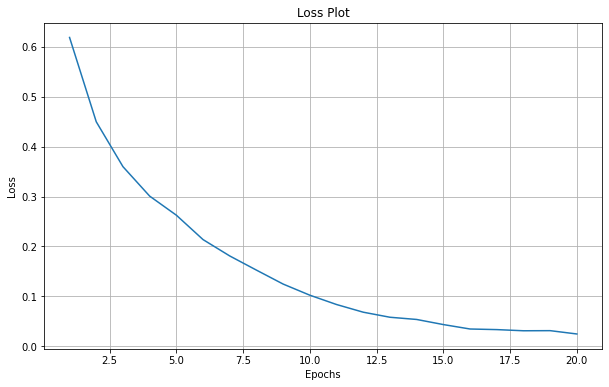

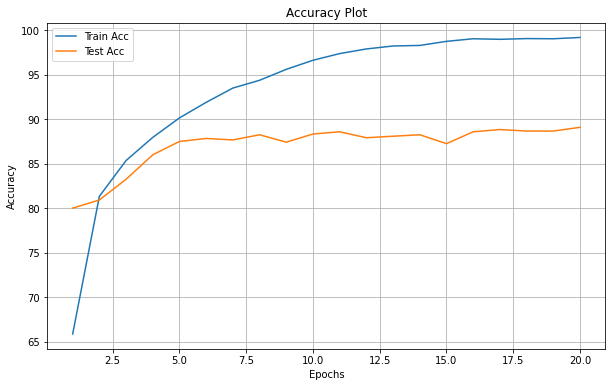

In [12]:
# Plot the results
plot_loss(train_losses, "Loss Plot", "Train Loss", "Loss", loss_save_path)
plot_accuracies(train_accuracies, test_accuracies, "Accuracy Plot", "Train Acc", "Test Acc", "Accuracy", acc_save_path)

In [13]:
# Get failed examples
failed_examples = get_failed_examples(model, test_loader_news, tokenizer)

2024-06-04 02:49:07.387703: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 02:49:07.437763: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# Print decoded sentences
for example in failed_examples:
    print(example["decoded_sentence"], example["label"], example["prediction"])

football - loving americans harassed for wearing turbans to nfl game 0 1
get clarity on what the future holds so you can go back to worrying about costume ideas. 1 0
mark sanford's fiancee found out about split from facebook post 0 1
pillsbury doughboy's image sexed up 1 0
justin timberlake tells jessica biel no one will believe her 1 0
olympics commentator explains'they all look the same'remark about chinese skiers 0 1
scottish leader demands new referendum on independence 0 1
caitlyn jenner on bathing suits :'don't know if i'm ready to expose myself ' 0 1
ed mcmahon endorses another depressing product 1 0
bush surges ahead in polls after strong showing on pommel horse 1 0
proud son posts pic of folks who graduated college after addiction 0 1
feeling the heat in alabama's senate race, luther strange calls for filibuster change 0 1
dismembered nate silver found in dumpster behind gallup headquarters 1 0
scientists identify possible cause of huge ice shelf collapse 0 1
only two segways 